In [11]:
import numpy as np
import pandas as pd
import utm
import math
import pickle
import os
import sys
sys.path.append('./src')
import time
import datetime
from collections import defaultdict
import matplotlib
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString
import copy
import tensorflow as tf
from importlib import reload

import load, plot
import tools
import pygrid
import process

# Load Data

In [6]:
dataset = 'jiading'
datatype = '2g'
data_file = './data/%s_%s/data_%s.csv' % (dataset, datatype, datatype)
gongcan_file = './data/%s_%s/gongcan_%s.csv' % (dataset, datatype, datatype)
disp_path = './display/%s_%s/' % (dataset, datatype)
data_path = './data/%s_%s/' % (dataset, datatype)
map_file = './data/%s_map/%s_EdgeGeometry.txt' % (dataset, dataset)

In [14]:
load = reload(load)
tools = reload(tools)
df = load.load_data(data_file, gongcan_file)
max_dist, min_dist, min_len, max_again = load.get_config(dataset, datatype)
df_new = load.clean_data(df, max_dist, min_dist, min_len, max_again, debug=True)

Traj ID=0
0->1:286m	
discard[0:0]=0m	keep[1:25]as id=0	
Traj ID=1
32->33:510m	
discard[25:32]=0m	keep[33:183]as id=1	
Traj ID=2
184->185:330m	
discard[183:184]=0m	keep[185:261]as id=2	
Traj ID=3

keep[261:295]as id=3	
Traj ID=4
295->296:394m	
discard[295:295]=0m	keep[296:340]as id=4	
Traj ID=5
341->342:118m	
discard[340:341]=0m	keep[342:390]as id=5	
Traj ID=6
391->392:522m	502->503:752m	523->524:116m	
discard[390:391]=0m	trimed[0,89] keep[392:413]as id=6	discard[503:523]=33m	discard[524:525]=0m	
Traj ID=7
535->536:101m	
discard[526:535]=0m	keep[536:639]as id=7	
Traj ID=8

keep[639:1013]as id=8	
Traj ID=9
1014->1015:947m	
discard[1013:1014]=0m	keep[1015:1355]as id=9	
Traj ID=10

keep[1355:1776]as id=10	
Traj ID=11

keep[1776:2072]as id=11	
Traj ID=12

keep[2072:2495]as id=12	
Traj ID=13
2530->2531:838m	
discard[2495:2530]=0m	keep[2531:3528]as id=13	
Traj ID=14

keep[3528:4371]as id=14	
Traj ID=15
4413->4414:667m	
keep[4371:4414]as id=15	keep[4414:4487]as id=16	
Traj ID=16
4489->4490:482

In [17]:
df_new.to_csv(data_path + 'data_' + datatype + '_clean.csv')

In [15]:
time_diff = []
max_trid = max(df_new['TrajID'])
for tr_id in range(max_trid + 1):
    df_i = df_new[df_new['TrajID'] == tr_id]
    for idx, a in enumerate(list(df_i.index)):
        if idx == 0:
            time_diff.append(0)
            continue
        time_diff.append(int(df_i.loc[a]['MRTime']) - int(df_i.loc[a-1]['MRTime']))
df_new['TimeDiff'] = time_diff
df_new['TimeDiff'].describe()

count    12710.000000
mean         2.046892
std          1.004360
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         12.000000
Name: TimeDiff, dtype: float64

# Find Patterns

In [18]:
pygrid = reload(pygrid)
if dataset == 'jiading':
    bounding_box = (328500, 330600, 3462100, 3463600)
elif dataset == 'siping':
    bounding_box = (356000, 359000, 3461500, 3463000)
side = 20
grid = pygrid.Grid(side, bounding_box)

In [71]:
process = reload(process)
towers, r_towers = load.load_gongcan(gongcan_file)
w_size = 7
cellids, patterns, statistic = process.retrive(df_new, grid, towers, w_size)

TrajID=0
TrajID=1
TrajID=2
TrajID=3
TrajID=4
TrajID=5
TrajID=6
TrajID=7
TrajID=8
TrajID=9
TrajID=10
TrajID=11
TrajID=12
TrajID=13
TrajID=14
TrajID=15
TrajID=16
TrajID=17
TrajID=18
TrajID=19
TrajID=20
TrajID=21
TrajID=22
TrajID=23
TrajID=24
TrajID=25
TrajID=26
TrajID=27
TrajID=28
TrajID=29
TrajID=30
TrajID=31
TrajID=32
TrajID=33
TrajID=34
TrajID=35
TrajID=36
TrajID=37
TrajID=38
TrajID=39
TrajID=40
TrajID=41
TrajID=42
TrajID=43
TrajID=44
TrajID=45
TrajID=46
TrajID=47
TrajID=48
TrajID=49
TrajID=50
TrajID=51
TrajID=52
TrajID=53
TrajID=54
TrajID=55
TrajID=56
TrajID=57
TrajID=58
TrajID=59
TrajID=60
TrajID=61
TrajID=62
TrajID=63
TrajID=64
TrajID=65
TrajID=66
TrajID=67
TrajID=68
TrajID=69
TrajID=70
TrajID=71
TrajID=72
TrajID=73


In [72]:
statistic.describe()

,width,height
count,12266.000000,12266.000000
mean,1.384314,1.428909
std,1.219436,1.282403
min,0.000000,0.000000
25%,1.000000,0.000000
50%,1.000000,1.000000
75%,2.000000,2.000000
max,9.000000,10.000000


In [73]:
len(cellids), len(patterns)

(12266, 12266)

In [74]:
cellids[0]

[[80, 88, 53, 79, 85, 84],
 [81, 88, 53, 79, 85, 84],
 [81, 88, 53, 79, 85, 84],
 [81, 88, 53, 79, 85, 84],
 [81, 88, 53, 79, 85, 84],
 [81, 88, 53, 79, 85, 84],
 [81, 88, 53, 79, 85, 84]]

In [75]:
patterns[0], patterns[1]

([4903, 4903, 4903, 4903, 4903, 5008, 5008],
 [4903, 4903, 4903, 4903, 5008, 5008, 5008])

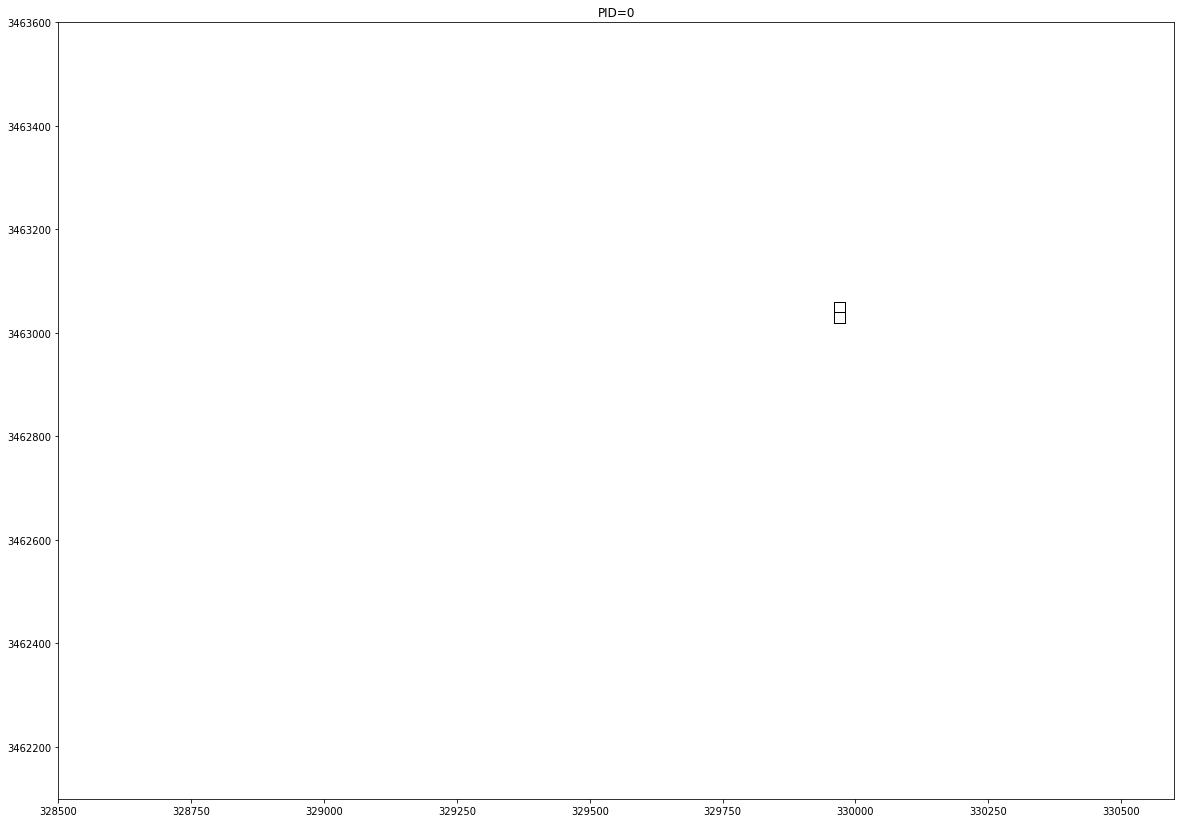

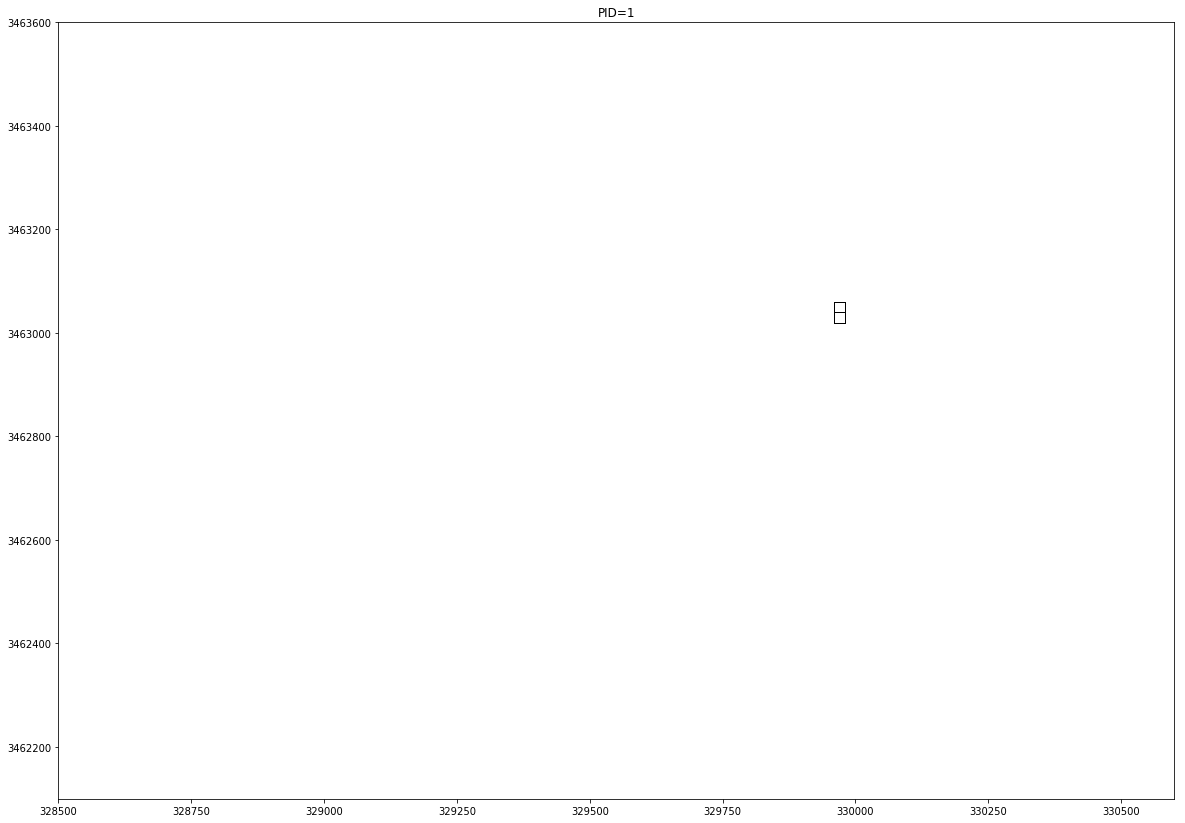

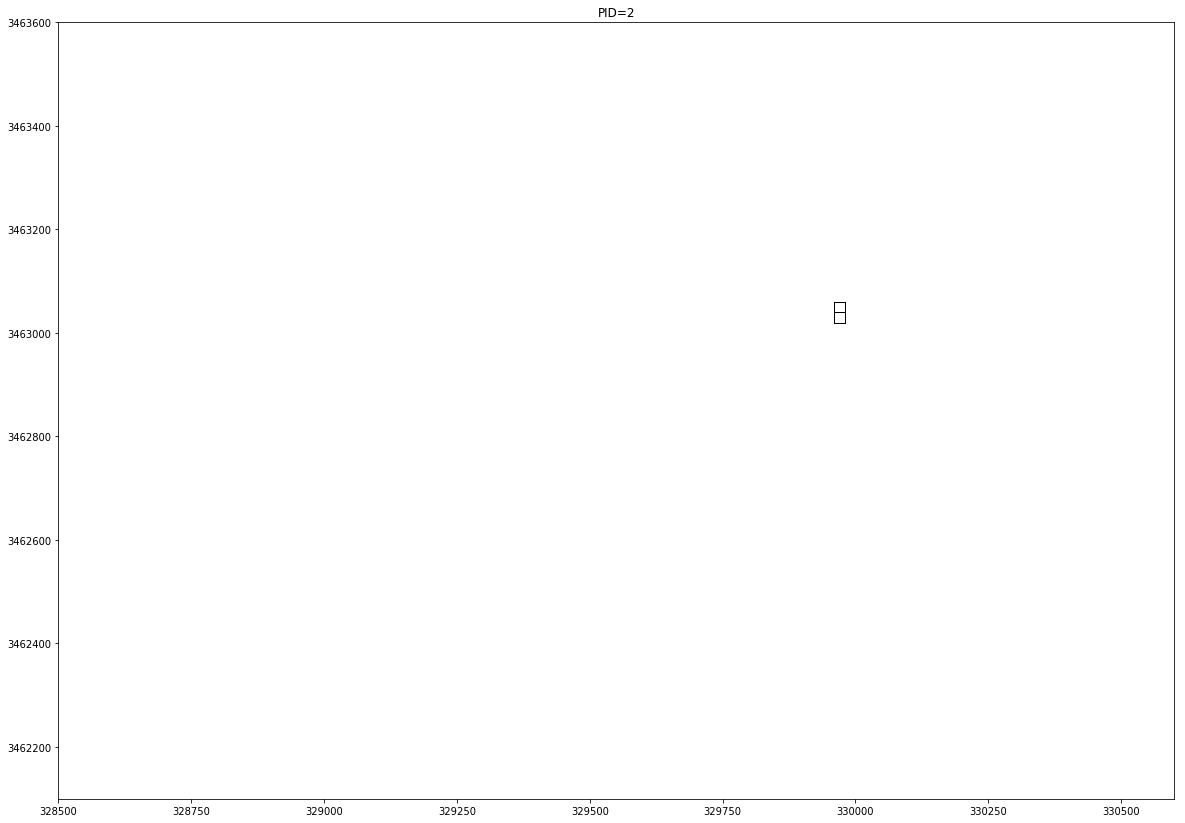

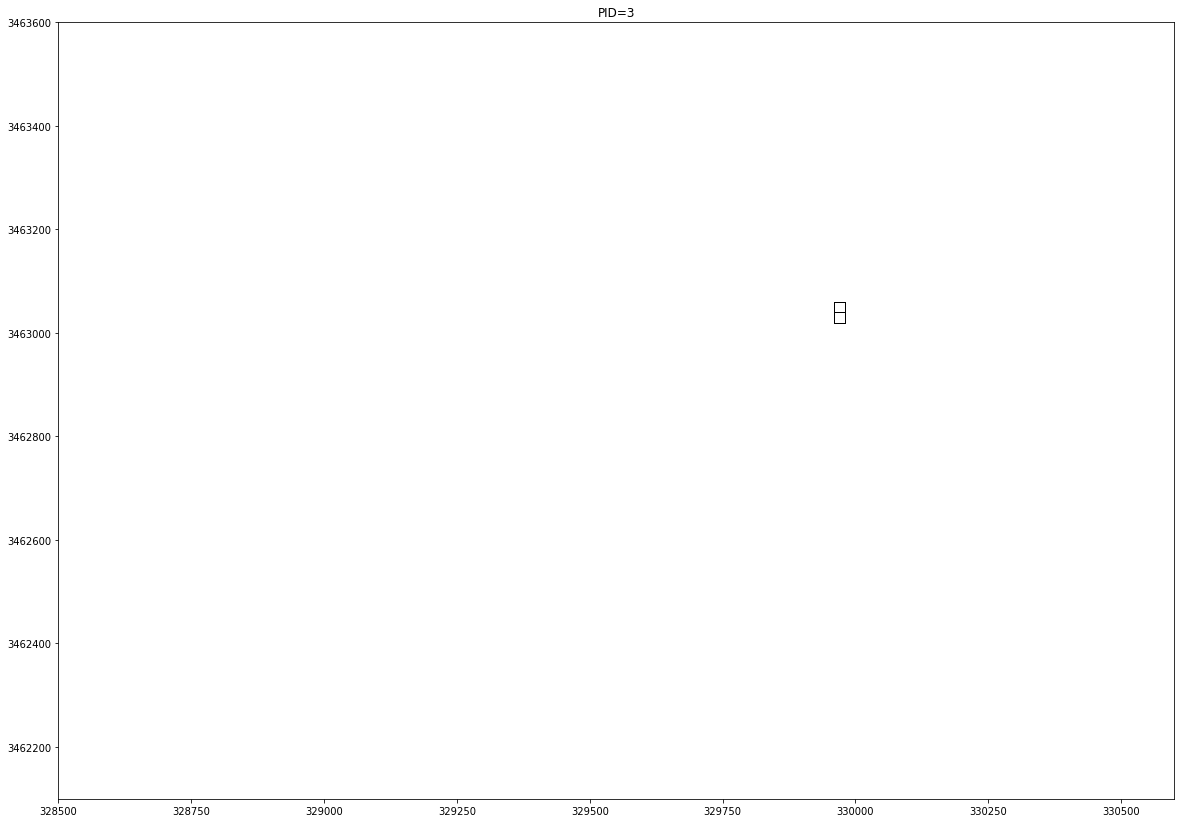

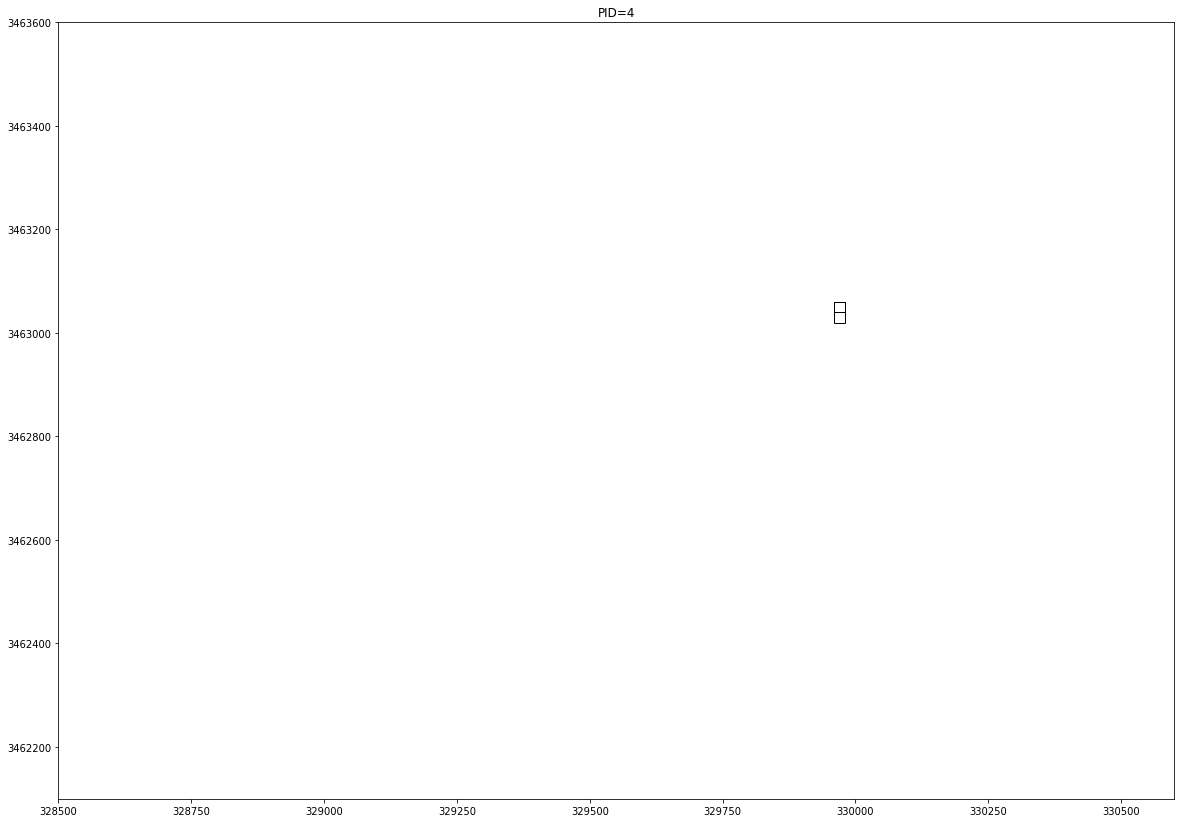

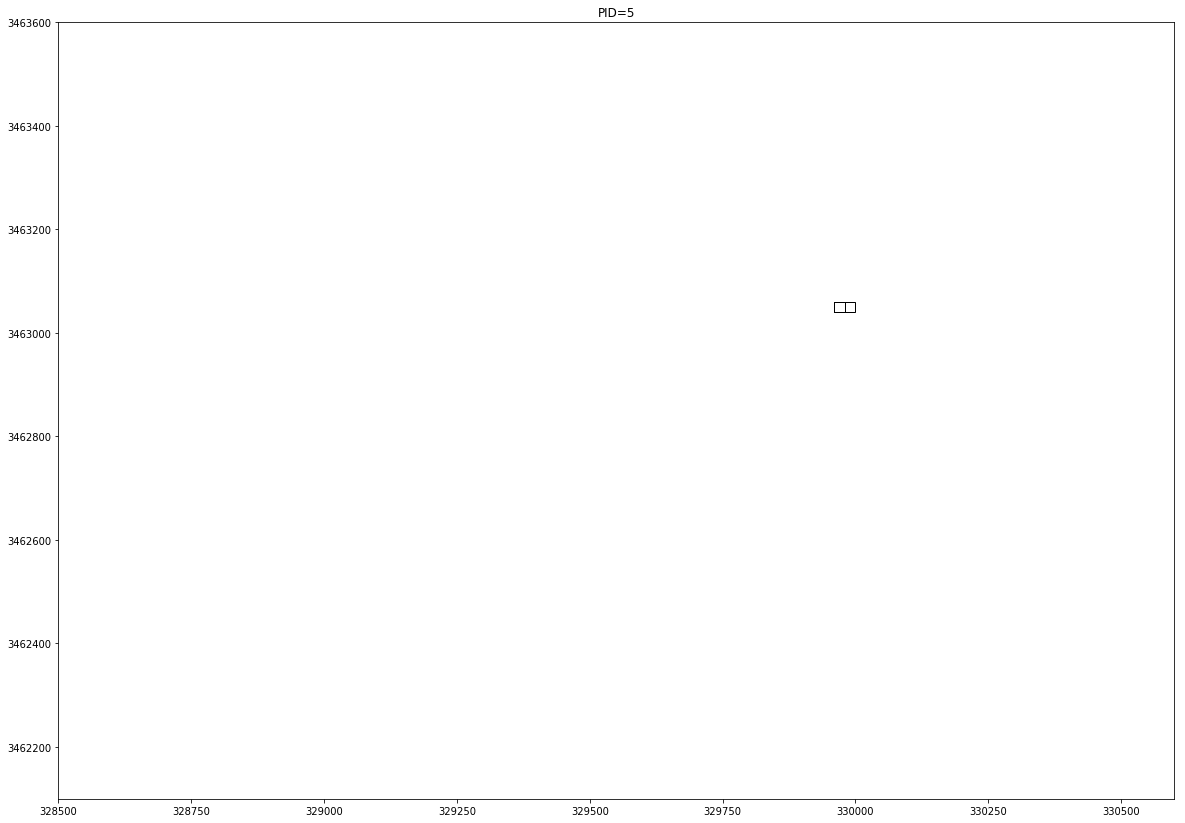

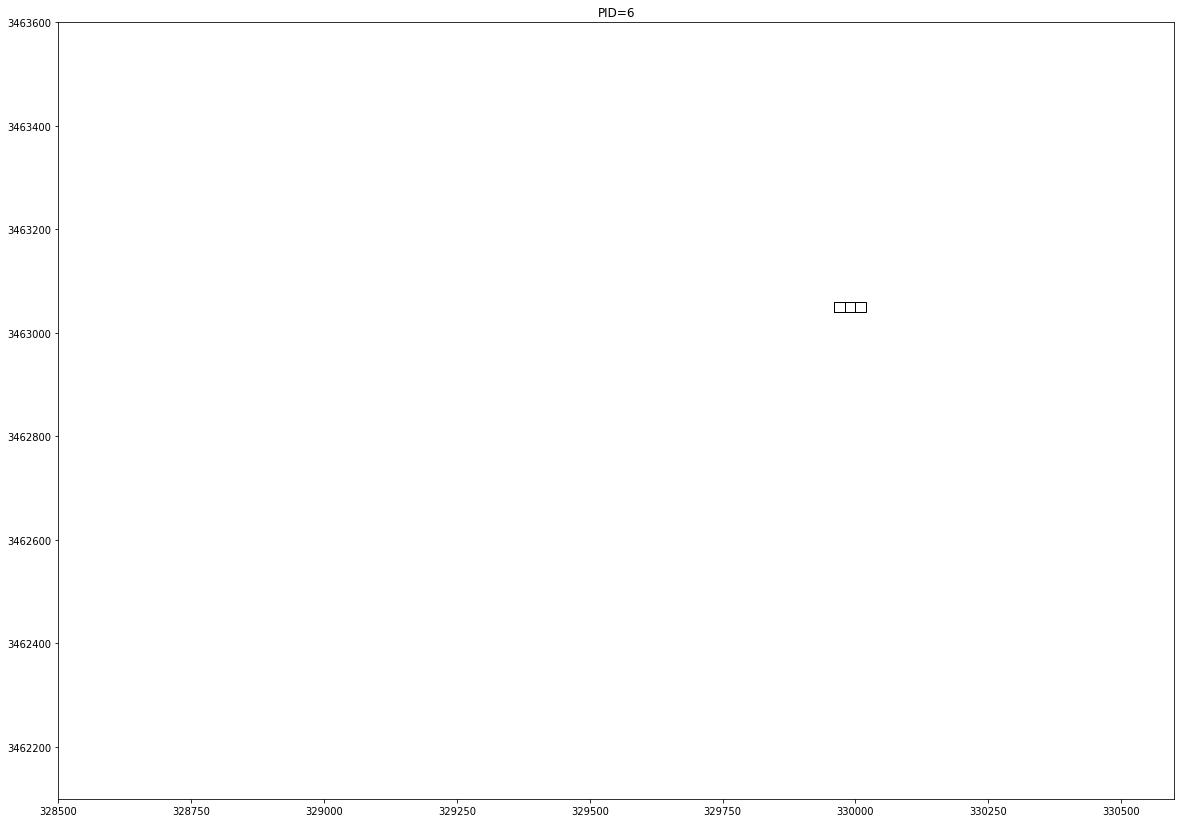

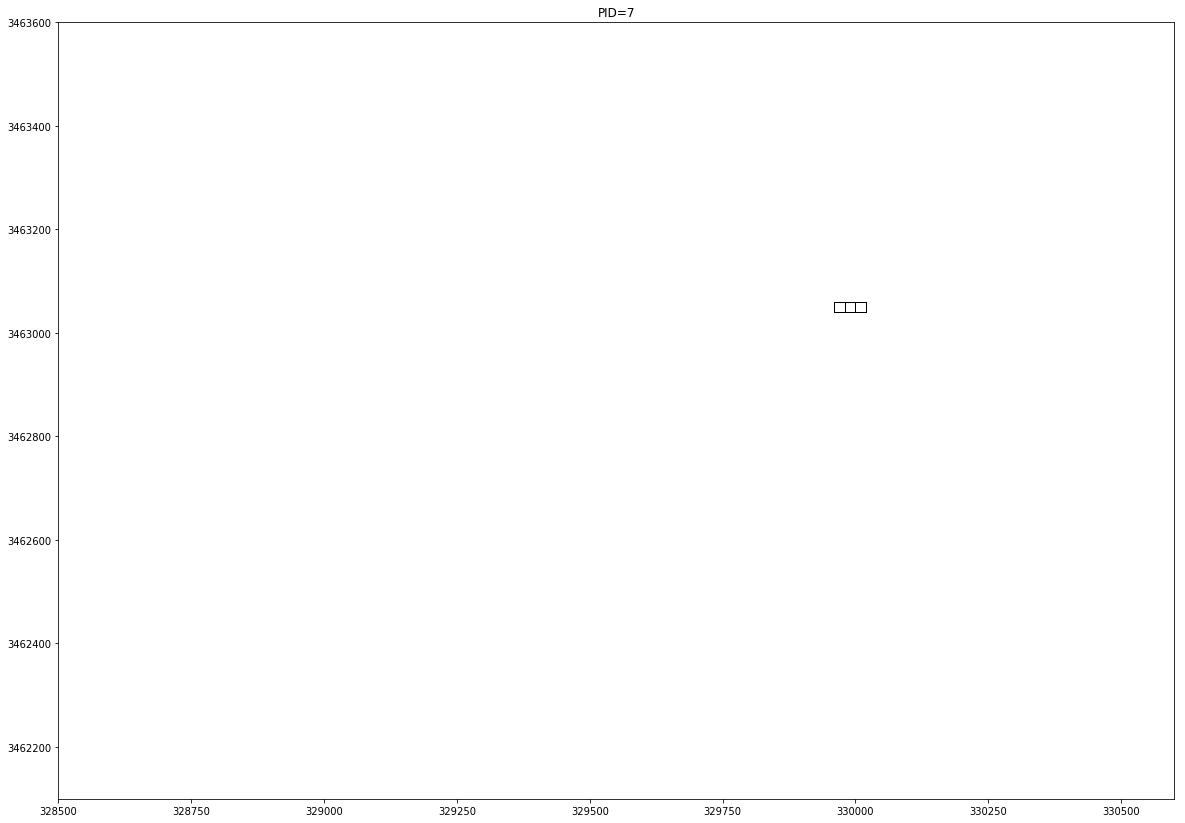

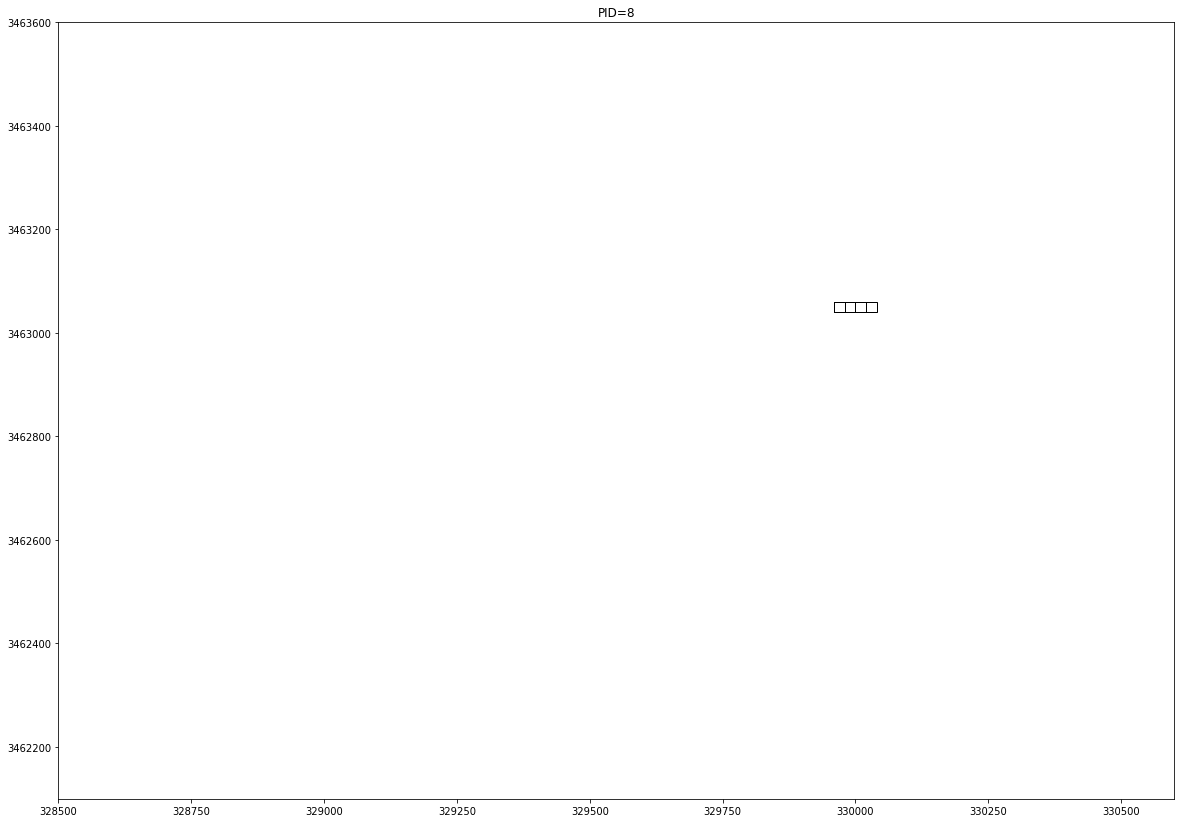

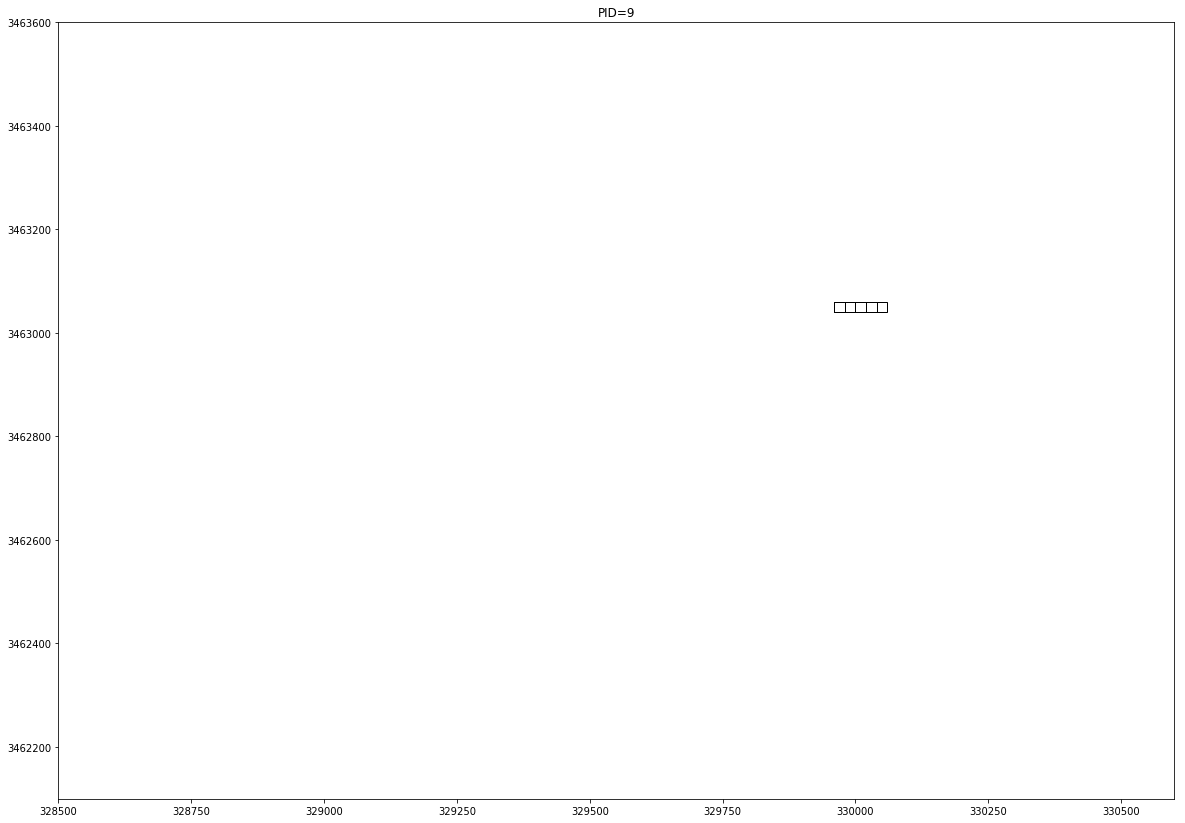

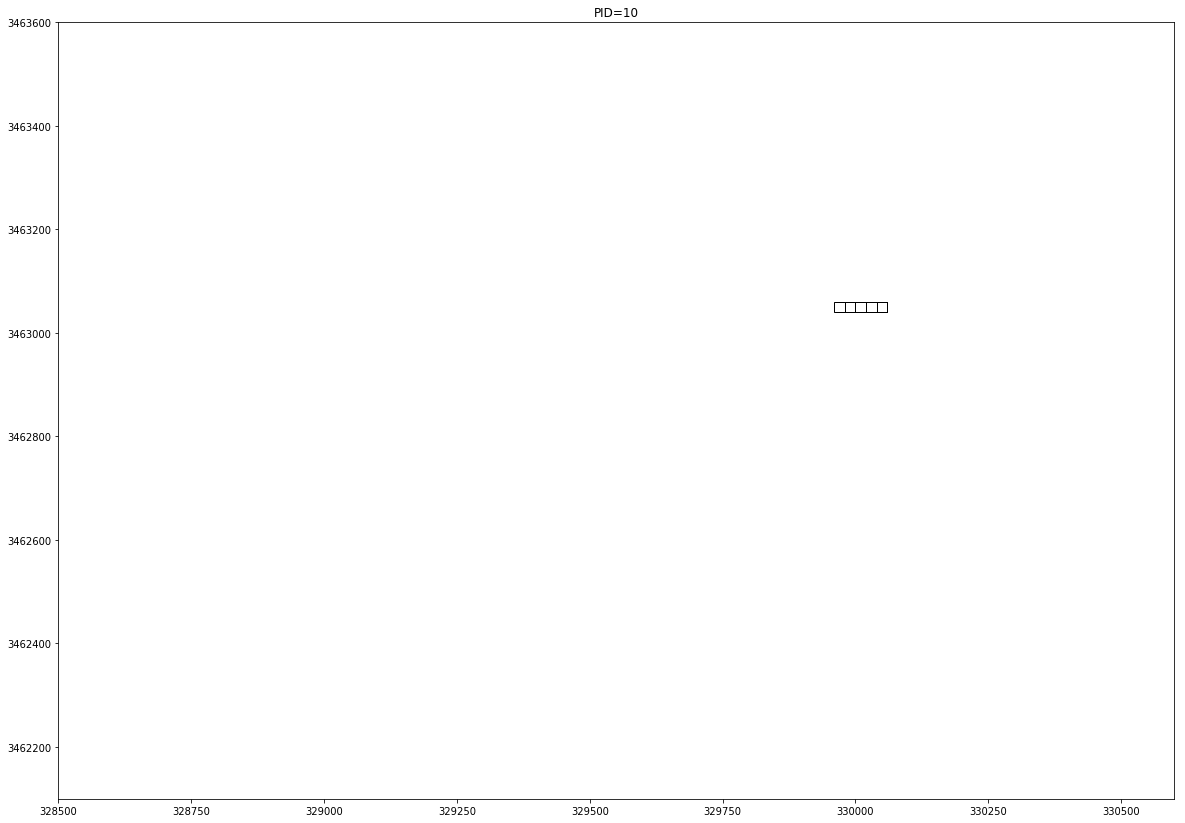

In [23]:
plot = reload(plot)
fig_width = 20
axis = bounding_box
for idx, pattern in enumerate(patterns):
    if idx > 10:
        break
    plt.figure(figsize=(fig_width, fig_width*(axis[3]-axis[2])/(axis[1]-axis[0])))
    ca = plt.gca()
    converted = []
    for cid in pattern:
        converted.append(grid.cell2box(cid))
    plot.draw_pattern(converted, side, ca, axis, 'k', debug=False)
    plt.axis(axis)
    plt.title('PID=' + str(idx))
    plt.show()

In [76]:
process = reload(process)
labels = process.pattern2label(patterns, grid, version=0)

In [77]:
labels

[(0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (1, 0),
 (2, 0),
 (2, 0),
 (3, 0),
 (4, 0),
 (4, 0),
 (4, 0),
 (3, 1),
 (4, 1),
 (3, 1),
 (3, 1),
 (3, 1),
 (3, 1),
 (-1, 0),
 (-1, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (0, 0),
 (0, 0),
 (-1, 0),
 (-2, 1),
 (-2, 1),
 (-1, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (1, -1),
 (1, -1),
 (0, 1),
 (0, 1),
 (0, 1),
 (-1, 1),
 (-1, 1),
 (-1, 1),
 (-1, 0),
 (-1, 0),
 (-1, 0),
 (-1, -1),
 (-1, -2),
 (-2, -3),
 (-2, -4),
 (-3, -5),
 (-3, -6),
 (-2, -7),
 (-3, -7),
 (-2, -7),
 (-2, -6),
 (-2, -6),
 (-3, -6),
 (-3, -4),
 (-3, -4),
 (-4, -5),
 (-4, -5),
 (-3, -5),
 (-3, -5),
 (-4, -6),
 (-3, -5),
 (-3, -4),
 (-3, -5),
 (-4, -5),
 (-3, -4),
 (-3, -5),
 (-3, -5),
 (-2, -6),
 (-3, -5),
 (-4, -4),
 (-4, -5),
 (-4, -3),
 (-5, -5),
 (-5, -3),
 (-5, -4),
 (-3, -5),
 (-4, -4),
 (-3, -5),
 (-3, -4),
 (-3, -4),
 (-2, -4),
 (-2, -4),
 (-1, -4),
 (0, -4),
 (2, -3),
 (2, -4),
 (3, -4),
 (3, -4),
 (4, -4),
 (3, -4),
 (2, -5),
 (3, -5),
 (2, -5),
 

In [78]:
features = process.cellids2feature(cellids, version=0)

In [79]:
new_labels = []
for label in labels:
    x, y = label
    if x < 0 and y > 0:
        new_label = 1
    elif x == 0 and y > 0:
        new_label = 2
    elif x > 0 and y > 0:
        new_label = 3
    elif x > 0 and y == 0:
        new_label = 4
    elif x > 0 and y < 0:
        new_label = 5
    elif x == 0 and y < 0:
        new_label = 6
    elif x < 0 and y < 0:
        new_label = 7
    elif x < 0 and y == 0:
        new_label = 8
    elif x == 0 and y == 0:
        new_label = 0
    new_labels.append(new_label)

# Split Data

In [94]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(features, new_labels, test_size=0.25)

In [95]:
len(X_train), len(X_test)

(9199, 3067)

# Try RandomForest

In [88]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import accuracy_score
model = RandomForestClassifier(n_estimators=200)
model.fit(X_train, Y_train)
Y_predict = model.predict(X_test)
# score = accuracy_score(new_labels, Y_train.round(), normalize=False)
score = process.accuracy(Y_test, Y_predict.round())
score

0.7277469840234757

# CNN Classification

In [96]:
from sklearn import preprocessing
X_train = preprocessing.scale(X_train)
X_tr = X_train.reshape(-1, w_size, 6, 1)
X_test = preprocessing.scale(X_test)
X_te = X_test.reshape(-1, w_size, 6, 1)

In [98]:
from keras.utils.np_utils import to_categorical
Y_tr = to_categorical(pd.DataFrame(Y_train), num_classes=None)
Y_te = to_categorical(pd.DataFrame(Y_test), num_classes=None)

Using TensorFlow backend.


In [101]:
num_class = 9

## TensorFlow Graph

In [104]:
tf.reset_default_graph()
# Input Layer
tf_X = tf.placeholder(tf.float32, [None, w_size, 6, 1])
tf_Y = tf.placeholder(tf.float32, [None, num_class])

# Conv Layer
conv_w1 = tf.Variable(tf.random_normal([w_size, 6, 1, num_class]))
conv_b1 = tf.Variable(tf.random_normal([num_class]))
relu_feature_map1 = tf.nn.relu(tf.nn.conv2d(tf_X, conv_w1, strides=[1,1,1,1], padding='SAME') + conv_b1)
print(relu_feature_map1)

# Pooling Layer
max_pool1 = tf.nn.max_pool(relu_feature_map1, ksize=[1,3,3,1], strides=[1,2,2,1], padding='SAME')

# Conv Layer 2
conv_w2 = tf.Variable(tf.random_normal([w_size, 6, num_class, 5]))
conv_b2 = tf.Variable(tf.random_normal([5]))
conv_out2 = tf.nn.conv2d(relu_feature_map1, conv_w2, strides=[1,2,2,1], padding='SAME') + conv_b2
print (conv_out2)

# Normalization
batch_mean, batch_var = tf.nn.moments(conv_out2, [0, 1, 2], keep_dims=True)
shift = tf.Variable(tf.zeros([5]))
scale = tf.Variable(tf.ones([5]))
epsilon = 1e-3
BN_out = tf.nn.batch_normalization(conv_out2, batch_mean, batch_var, shift, scale, epsilon)
print (BN_out)
relu_BN_map2 = tf.nn.relu(BN_out)

relu_BN_map2_flat = tf.reshape(relu_BN_map2, [-1, 4*4*5])

#Fully Connection
fc_w1 = tf.Variable(tf.random_normal([4*4*5, 64]))
fc_b1 = tf.Variable(tf.random_normal([64]))
fc_out1 = tf.nn.relu(tf.matmul(relu_BN_map2_flat, fc_w1) + fc_b1)

# Output Layer
out_w1 = tf.Variable(tf.random_normal([64, num_class]))
out_b1 = tf.Variable(tf.random_normal([num_class]))
pred = tf.nn.softmax(tf.matmul(fc_out1, out_w1) + out_b1)

Tensor("Relu:0", shape=(?, 7, 6, 9), dtype=float32)
Tensor("add_1:0", shape=(?, 4, 3, 5), dtype=float32)
Tensor("batchnorm/add_1:0", shape=(?, 4, 3, 5), dtype=float32)


In [105]:
loss = -tf.reduce_mean(tf_Y*tf.log(tf.clip_by_value(pred, 1e-11, 1.0)))
train_step = tf.train.AdamOptimizer(1e-3).minimize(loss)
y_pred = tf.arg_max(pred, 1)
bool_pred = tf.equal(tf.arg_max(tf_Y, 1), y_pred)

accuracy = tf.reduce_mean(tf.cast(bool_pred, tf.float32))

Instructions for updating:
Use `argmax` instead


In [108]:
def batch_get(X,Y,n_examples, batch_size):
    for batch_i in range(n_examples // batch_size):
        start = batch_i*batch_size
        end = start + batch_size
        batch_xs = X[start:end]
        batch_ys = Y[start:end]
        yield batch_xs, batch_ys # 生成每一个batch
batch_size = 20
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(500):
        for batch_xs, batch_ys in batch_get(X_tr, Y_tr, Y_tr.shape[0], batch_size):
            sess.run(train_step, feed_dict={tf_X:batch_xs, tf_Y:batch_ys})
        if epoch % 50 == 0:
            res = sess.run(accuracy, feed_dict={tf_X:X_tr, tf_Y:Y_tr})
            lo = sess.run(loss, feed_dict={tf_X:X_tr, tf_Y:Y_tr})
            print(epoch, lo, res)
        res_y_pred = y_pred.eval(feed_dict={tf_X:X_tr, tf_Y:Y_tr}).flatten()
        print (res_y_pred)
        te_y_pred = y_pred.eval(feed_dict={tf_X:X_te, tf_Y:Y_te}).flatten()
        loss_te = sess.run(loss, feed_dict={tf_X:X_te, tf_Y:Y_te})
        print(loss_te, te_y_pred)

InvalidArgumentError: Incompatible shapes: [20,9] vs. [15,9]
	 [[Node: gradients/mul_grad/BroadcastGradientArgs = BroadcastGradientArgs[T=DT_INT32, _device="/job:localhost/replica:0/task:0/device:CPU:0"](gradients/mul_grad/Shape, gradients/mul_grad/Shape_1)]]

Caused by op 'gradients/mul_grad/BroadcastGradientArgs', defined at:
  File "D:\Programs\Anaconda2\envs\py36\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "D:\Programs\Anaconda2\envs\py36\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "D:\Programs\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "D:\Programs\Anaconda2\envs\py36\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "D:\Programs\Anaconda2\envs\py36\lib\site-packages\ipykernel\kernelapp.py", line 486, in start
    self.io_loop.start()
  File "D:\Programs\Anaconda2\envs\py36\lib\site-packages\tornado\platform\asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "D:\Programs\Anaconda2\envs\py36\lib\asyncio\base_events.py", line 422, in run_forever
    self._run_once()
  File "D:\Programs\Anaconda2\envs\py36\lib\asyncio\base_events.py", line 1432, in _run_once
    handle._run()
  File "D:\Programs\Anaconda2\envs\py36\lib\asyncio\events.py", line 145, in _run
    self._callback(*self._args)
  File "D:\Programs\Anaconda2\envs\py36\lib\site-packages\tornado\platform\asyncio.py", line 117, in _handle_events
    handler_func(fileobj, events)
  File "D:\Programs\Anaconda2\envs\py36\lib\site-packages\tornado\stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "D:\Programs\Anaconda2\envs\py36\lib\site-packages\zmq\eventloop\zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "D:\Programs\Anaconda2\envs\py36\lib\site-packages\zmq\eventloop\zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "D:\Programs\Anaconda2\envs\py36\lib\site-packages\zmq\eventloop\zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "D:\Programs\Anaconda2\envs\py36\lib\site-packages\tornado\stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "D:\Programs\Anaconda2\envs\py36\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "D:\Programs\Anaconda2\envs\py36\lib\site-packages\ipykernel\kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "D:\Programs\Anaconda2\envs\py36\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "D:\Programs\Anaconda2\envs\py36\lib\site-packages\ipykernel\ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "D:\Programs\Anaconda2\envs\py36\lib\site-packages\ipykernel\zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "D:\Programs\Anaconda2\envs\py36\lib\site-packages\IPython\core\interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "D:\Programs\Anaconda2\envs\py36\lib\site-packages\IPython\core\interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "D:\Programs\Anaconda2\envs\py36\lib\site-packages\IPython\core\interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "D:\Programs\Anaconda2\envs\py36\lib\site-packages\IPython\core\interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-105-df5ad129adda>", line 2, in <module>
    train_step = tf.train.AdamOptimizer(1e-3).minimize(loss)
  File "D:\Programs\Anaconda2\envs\py36\lib\site-packages\tensorflow\python\training\optimizer.py", line 414, in minimize
    grad_loss=grad_loss)
  File "D:\Programs\Anaconda2\envs\py36\lib\site-packages\tensorflow\python\training\optimizer.py", line 526, in compute_gradients
    colocate_gradients_with_ops=colocate_gradients_with_ops)
  File "D:\Programs\Anaconda2\envs\py36\lib\site-packages\tensorflow\python\ops\gradients_impl.py", line 494, in gradients
    gate_gradients, aggregation_method, stop_gradients)
  File "D:\Programs\Anaconda2\envs\py36\lib\site-packages\tensorflow\python\ops\gradients_impl.py", line 636, in _GradientsHelper
    lambda: grad_fn(op, *out_grads))
  File "D:\Programs\Anaconda2\envs\py36\lib\site-packages\tensorflow\python\ops\gradients_impl.py", line 385, in _MaybeCompile
    return grad_fn()  # Exit early
  File "D:\Programs\Anaconda2\envs\py36\lib\site-packages\tensorflow\python\ops\gradients_impl.py", line 636, in <lambda>
    lambda: grad_fn(op, *out_grads))
  File "D:\Programs\Anaconda2\envs\py36\lib\site-packages\tensorflow\python\ops\math_grad.py", line 874, in _MulGrad
    rx, ry = gen_array_ops.broadcast_gradient_args(sx, sy)
  File "D:\Programs\Anaconda2\envs\py36\lib\site-packages\tensorflow\python\ops\gen_array_ops.py", line 812, in broadcast_gradient_args
    "BroadcastGradientArgs", s0=s0, s1=s1, name=name)
  File "D:\Programs\Anaconda2\envs\py36\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "D:\Programs\Anaconda2\envs\py36\lib\site-packages\tensorflow\python\framework\ops.py", line 3392, in create_op
    op_def=op_def)
  File "D:\Programs\Anaconda2\envs\py36\lib\site-packages\tensorflow\python\framework\ops.py", line 1718, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

...which was originally created as op 'mul', defined at:
  File "D:\Programs\Anaconda2\envs\py36\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
[elided 22 identical lines from previous traceback]
  File "D:\Programs\Anaconda2\envs\py36\lib\site-packages\IPython\core\interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-105-df5ad129adda>", line 1, in <module>
    loss = -tf.reduce_mean(tf_Y*tf.log(tf.clip_by_value(pred, 1e-11, 1.0)))
  File "D:\Programs\Anaconda2\envs\py36\lib\site-packages\tensorflow\python\ops\math_ops.py", line 979, in binary_op_wrapper
    return func(x, y, name=name)
  File "D:\Programs\Anaconda2\envs\py36\lib\site-packages\tensorflow\python\ops\math_ops.py", line 1211, in _mul_dispatch
    return gen_math_ops.mul(x, y, name=name)
  File "D:\Programs\Anaconda2\envs\py36\lib\site-packages\tensorflow\python\ops\gen_math_ops.py", line 5066, in mul
    "Mul", x=x, y=y, name=name)
  File "D:\Programs\Anaconda2\envs\py36\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "D:\Programs\Anaconda2\envs\py36\lib\site-packages\tensorflow\python\framework\ops.py", line 3392, in create_op
    op_def=op_def)
  File "D:\Programs\Anaconda2\envs\py36\lib\site-packages\tensorflow\python\framework\ops.py", line 1718, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): Incompatible shapes: [20,9] vs. [15,9]
	 [[Node: gradients/mul_grad/BroadcastGradientArgs = BroadcastGradientArgs[T=DT_INT32, _device="/job:localhost/replica:0/task:0/device:CPU:0"](gradients/mul_grad/Shape, gradients/mul_grad/Shape_1)]]
